In [2]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping

In [3]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import keras
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = np.asarray(df[name], dtype = np.float).mean()

    if sd is None:
        sd = np.asarray(df[name], dtype = np.float).std()

    df[name] = (np.asarray(df[name], dtype = np.float) - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

In [5]:

# This file is a CSV, just no CSV extension or headers
# Download from: http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
df_ = pd.read_csv("/Users/tsaiflow/Desktop/NN&Sampling/data_ddos_kdd/train_PKT_sampling@80_50%.csv")

print("Read {} rows.".format(len(df_)))
#print("Read {} rows.".format(len(df1)))
# df = df.sample(frac=0.1, replace=False) # Uncomment this line to sample only 10% of the dataset
df_.dropna(inplace=True,axis=1) # For now, just drop NA's (rows with missing values)
# df1.dropna(inplace=True,axis=1)

# The CSV file has no column heads, so add them
# df.columns = [
#     'duration',
#     'forw_bytes',
#     'back_bytes',
#     'total_bytes',
    
#     'outcome'
# ]

Read 35767 rows.


In [6]:
df_.head(5)

,Unnamed: 0,duration,forw_byte,back_byte,tot_byte,outcome
0,0,0.0,520,0,520,dos
1,1,0.0,1032,0,1032,dos
2,2,0.0,1032,0,1032,dos
3,3,0.0,1032,0,1032,dos
4,4,0.0,1032,0,1032,dos


In [7]:
cols = ['duration', 'forw_byte', 'back_byte','tot_byte','outcome']
df = df_[cols]

In [8]:
# df.drop(df.head(1).index, inplace = True)

In [9]:
df.head(5)

,duration,forw_byte,back_byte,tot_byte,outcome
0,0.0,520,0,520,dos
1,0.0,1032,0,1032,dos
2,0.0,1032,0,1032,dos
3,0.0,1032,0,1032,dos
4,0.0,1032,0,1032,dos


In [10]:
# np.asarray(df['duration'], dtype = np.float).mean()
# # df[name].mean()

In [11]:
# np.asarray(df['duration'], dtype = np.float).std()

In [12]:
# Now encode the feature vector

#encode_numeric_zscore(df, 'duration')

# encode_text_dummy(df, 'protocol_type')
# encode_text_dummy(df, 'service')
# encode_text_dummy(df, 'flag')
encode_numeric_zscore(df, 'forw_byte')
encode_numeric_zscore(df, 'back_byte')
encode_numeric_zscore(df, 'tot_byte')
# encode_text_dummy(df, 'land')
# encode_numeric_zscore(df, 'wrong_fragment')
# encode_numeric_zscore(df, 'urgent')
# encode_numeric_zscore(df, 'hot')
# encode_numeric_zscore(df, 'num_failed_logins')
# encode_text_dummy(df, 'logged_in')
# encode_numeric_zscore(df, 'num_compromised')
# encode_numeric_zscore(df, 'root_shell')
# encode_numeric_zscore(df, 'su_attempted')
# encode_numeric_zscore(df, 'num_root')
# encode_numeric_zscore(df, 'num_file_creations')
# encode_numeric_zscore(df, 'num_shells')
# encode_numeric_zscore(df, 'num_access_files')
# encode_numeric_zscore(df, 'num_outbound_cmds')
# encode_text_dummy(df, 'is_host_login')
# encode_text_dummy(df, 'is_guest_login')
# encode_numeric_zscore(df, 'count')
# encode_numeric_zscore(df, 'srv_count')
# encode_numeric_zscore(df, 'serror_rate')
# encode_numeric_zscore(df, 'srv_serror_rate')
# encode_numeric_zscore(df, 'rerror_rate')
# encode_numeric_zscore(df, 'srv_rerror_rate')
# encode_numeric_zscore(df, 'same_srv_rate')
# encode_numeric_zscore(df, 'diff_srv_rate')
# encode_numeric_zscore(df, 'srv_diff_host_rate')
# encode_numeric_zscore(df, 'dst_host_count')
# encode_numeric_zscore(df, 'dst_host_srv_count')
# encode_numeric_zscore(df, 'dst_host_same_srv_rate')
# encode_numeric_zscore(df, 'dst_host_diff_srv_rate')
# encode_numeric_zscore(df, 'dst_host_same_src_port_rate')
# encode_numeric_zscore(df, 'dst_host_srv_diff_host_rate')
# encode_numeric_zscore(df, 'dst_host_serror_rate')
# encode_numeric_zscore(df, 'dst_host_srv_serror_rate')
# encode_numeric_zscore(df, 'dst_host_rerror_rate')
# encode_numeric_zscore(df, 'dst_host_srv_rerror_rate')
outcomes = encode_text_index(df, 'outcome')
num_classes = len(outcomes)

# display 5 rows

df.dropna(inplace=True,axis=1)
df[0:5]
# This is the numeric feature vector, as it goes to the neural net

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,duration,forw_byte,back_byte,tot_byte,outcome
0,0.0,-0.006669,-0.006377,-0.009210,0
1,0.0,-0.006583,-0.006377,-0.009146,0
2,0.0,-0.006583,-0.006377,-0.009146,0
3,0.0,-0.006583,-0.006377,-0.009146,0
4,0.0,-0.006583,-0.006377,-0.009146,0


In [13]:
x, y = to_xy(df,'outcome')

In [14]:
# df.head(5)

In [15]:
# Create a test/train split.  33% test
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.33, random_state=42)

In [16]:
import keras.backend as K
K.clear_session()

In [17]:
# Create neural net
model = Sequential()

# Used relu for activation function
model.add(Dense(10, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(50, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(10, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))

# output layer 
model.add(Dense(1, kernel_initializer='normal'))
model.add(Dense(y.shape[1],activation='softmax'))
# model.add(Dense(y.shape[1],activation = 'sigmoid'))

In [18]:
# Print the model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                50        
_________________________________________________________________
dense_2 (Dense)              (None, 50)                550       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 4         
Total params: 1,125
Trainable params: 1,125
Non-trainable params: 0
_________________________________________________________________


In [19]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        # TODO:  Create two empty lists, self.loss and self.val_acc
        self.losses = []
        self.accs = []
        self.val_acc = []
        self.val_loss = []
    def on_batch_end(self, batch, logs={}):
        # TODO:  This is called at the end of each batch.  
        # Add the loss in logs.get('loss') to the loss list
        loss = logs.get('loss')
        acc = logs.get('acc')
        self.losses.append(loss)
        self.accs.append(acc)
    def on_epoch_end(self, epoch, logs):
        # TODO:  This is called at the end of each epoch.  
        # Add the test accuracy in logs.get('loss') to the val_acc list
        val_acc = logs.get('val_acc')
        val_loss = logs.get('val_loss')
        self.val_acc.append(val_acc)
        self.val_loss.append(val_loss)

# Create an instance of the history callback
history_cb = LossHistory()

In [20]:
from keras import optimizers

# optimizer defined
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

In [21]:
## compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')


In [22]:
# model.fit(x,y,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)

In [23]:
batch_size = 200
epochs = 200
model.fit(x_train,y_train,callbacks=[history_cb],validation_data=(x_test,y_test),verbose=1,epochs=epochs,batch_size=batch_size)

Train on 23963 samples, validate on 11804 samples
Epoch 1/200
23963/23963 [==============================] - 0s - loss: 0.6691 - acc: 0.5884 - val_loss: 0.6159 - val_acc: 0.6221
Epoch 2/200
23963/23963 [==============================] - 0s - loss: 0.5957 - acc: 0.6457 - val_loss: 0.5742 - val_acc: 0.6724
Epoch 3/200
23963/23963 [==============================] - 0s - loss: 0.5403 - acc: 0.7050 - val_loss: 0.4951 - val_acc: 0.7447
Epoch 4/200
23963/23963 [==============================] - 0s - loss: 0.4413 - acc: 0.8019 - val_loss: 0.3869 - val_acc: 0.8305
Epoch 5/200
23963/23963 [==============================] - 0s - loss: 0.3516 - acc: 0.8465 - val_loss: 0.3223 - val_acc: 0.8827
Epoch 6/200
23963/23963 [==============================] - 0s - loss: 0.2973 - acc: 0.8771 - val_loss: 0.2721 - val_acc: 0.8993
Epoch 7/200
23963/23963 [==============================] - 0s - loss: 0.2626 - acc: 0.9023 - val_loss: 0.2387 - val_acc: 0.9136
Epoch 8/200
23963/23963 [=============================

23963/23963 [==============================] - 0s - loss: 0.1285 - acc: 0.9658 - val_loss: 0.1238 - val_acc: 0.9659
Epoch 65/200
23963/23963 [==============================] - 0s - loss: 0.1325 - acc: 0.9653 - val_loss: 0.1262 - val_acc: 0.9642
Epoch 66/200
23963/23963 [==============================] - 0s - loss: 0.1325 - acc: 0.9657 - val_loss: 0.1378 - val_acc: 0.9636
Epoch 67/200
23963/23963 [==============================] - 0s - loss: 0.1275 - acc: 0.9658 - val_loss: 0.1238 - val_acc: 0.9645
Epoch 68/200
23963/23963 [==============================] - 0s - loss: 0.1297 - acc: 0.9660 - val_loss: 0.1376 - val_acc: 0.9637
Epoch 69/200
23963/23963 [==============================] - 0s - loss: 0.1306 - acc: 0.9660 - val_loss: 0.1235 - val_acc: 0.9661
Epoch 70/200
23963/23963 [==============================] - 0s - loss: 0.1246 - acc: 0.9661 - val_loss: 0.1280 - val_acc: 0.9642
Epoch 71/200
23963/23963 [==============================] - 0s - loss: 0.1337 - acc: 0.9661 - val_loss: 0.1660

23963/23963 [==============================] - 0s - loss: 0.1238 - acc: 0.9688 - val_loss: 0.1193 - val_acc: 0.9687
Epoch 128/200
23963/23963 [==============================] - 0s - loss: 0.1215 - acc: 0.9685 - val_loss: 0.1199 - val_acc: 0.9686
Epoch 129/200
23963/23963 [==============================] - 0s - loss: 0.1205 - acc: 0.9690 - val_loss: 0.1192 - val_acc: 0.9687
Epoch 130/200
23963/23963 [==============================] - 0s - loss: 0.1240 - acc: 0.9687 - val_loss: 0.1191 - val_acc: 0.9687
Epoch 131/200
23963/23963 [==============================] - 0s - loss: 0.1201 - acc: 0.9688 - val_loss: 0.1245 - val_acc: 0.9690
Epoch 132/200
23963/23963 [==============================] - 0s - loss: 0.1279 - acc: 0.9681 - val_loss: 0.1286 - val_acc: 0.9690
Epoch 133/200
23963/23963 [==============================] - 0s - loss: 0.1223 - acc: 0.9686 - val_loss: 0.1242 - val_acc: 0.9690
Epoch 134/200
23963/23963 [==============================] - 0s - loss: 0.1237 - acc: 0.9683 - val_loss:

23963/23963 [==============================] - 0s - loss: 0.1198 - acc: 0.9693 - val_loss: 0.1214 - val_acc: 0.9690
Epoch 191/200
23963/23963 [==============================] - 0s - loss: 0.1196 - acc: 0.9694 - val_loss: 0.1180 - val_acc: 0.9690
Epoch 192/200
23963/23963 [==============================] - 0s - loss: 0.1228 - acc: 0.9690 - val_loss: 0.1209 - val_acc: 0.9687
Epoch 193/200
23963/23963 [==============================] - 0s - loss: 0.1183 - acc: 0.9695 - val_loss: 0.1220 - val_acc: 0.9687
Epoch 194/200
23963/23963 [==============================] - 0s - loss: 0.1207 - acc: 0.9694 - val_loss: 0.1185 - val_acc: 0.9689
Epoch 195/200
23963/23963 [==============================] - 0s - loss: 0.1182 - acc: 0.9694 - val_loss: 0.1546 - val_acc: 0.9690
Epoch 196/200
23963/23963 [==============================] - 0s - loss: 0.1212 - acc: 0.9691 - val_loss: 0.1189 - val_acc: 0.9690
Epoch 197/200
23963/23963 [==============================] - 0s - loss: 0.1211 - acc: 0.9692 - val_loss:

In [24]:
# Measure accuracy
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_eval = np.argmax(y_test,axis=1)
score = metrics.accuracy_score(y_eval, pred)
print("Validation score: {}".format(score))

Validation score: 0.9689935615045747


In [25]:
from sklearn.metrics import classification_report,confusion_matrix
Cm = confusion_matrix(y_eval,pred)
C = np.sum(Cm)
Cm = Cm/C
print('Confusion Matrix:')
print(np.array_str(Cm, precision=4, suppress_small=True))

Confusion Matrix:
[[ 0.5026  0.0001]
 [ 0.0309  0.4664]]


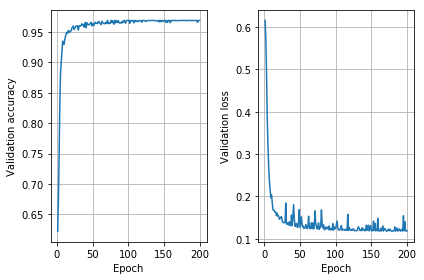

In [26]:
valAcc = history_cb.val_acc
valLoss = history_cb.val_loss
epoch_it = np.arange(1,201)
plt.subplot(121)
plt.plot(epoch_it, valAcc)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.tight_layout()
plt.subplot(122)
plt.plot(epoch_it, valLoss)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Validation loss')
plt.tight_layout()
plt.show()

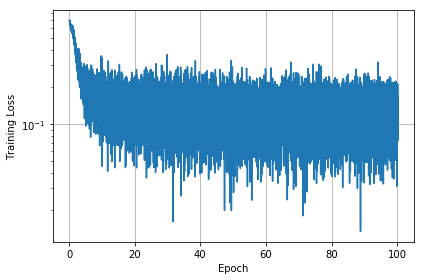

In [28]:
Ls = history_cb.losses
Acc = history_cb.accs
ntr = np.shape(x_train)[0]
epochNum = []
for i in range(24000):
    epochNum.append(i*100/ntr)

matplotlib.pyplot.semilogy(epochNum, Ls)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.tight_layout()
plt.show()

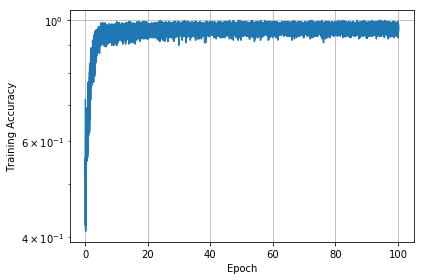

In [29]:
matplotlib.pyplot.semilogy(epochNum, Acc)
# plt.plot(epochNum, Acc)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.tight_layout()
# plt.axis([0.3,3,0.96,1])
plt.show()



In [ ]:
# # Save & Load result
# import os
# import tensorflow as tf
# saver = tf.train.Saver()

In [ ]:
# save_dir = 'checkpoints/' 

In [ ]:
# if not os.path.exists(save_dir):
#     os.makedirs(save_dir)

In [ ]:
# save_path = os.path.join(save_dir, 'best_validation')

In [ ]:
# saver.save(sess=session, save_path=save_path)

In [ ]:
# saver.restore(sess=session, save_path=save_path)

In [ ]:
# session.run(tf.global_variables_initializer())

In [ ]:
# print_test_accuracy(show_example_errors=True)